<a href="https://colab.research.google.com/github/TUMH0404/data/blob/master/0101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリのインポート

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats

## データを整理する[重要]

データは2021年11月16日～23日の心拍数と歩数が日別にそれぞれファイルに保存されている。ファイル内は、時系列（00:00:00）で15分おきに、心拍数および歩数が記録されている。これらのデータを一つずつ取得する必要がある。

## stepのデータ

In [9]:
myd1 = {}
for i in range(16,24,1):
    date = f"2021-11-{i}"
    try:    
        file1 = f"https://raw.githubusercontent.com/TUMH0404/data/master/2021_samp/step_{date}.txt"
        dat1 = pd.read_csv(file1)
    except:
        dat1 = pd.DataFrame({"time":[],"value":[]})

    myd1.update({date:dat1})


## HRのデータ

In [10]:
myd2 = {}
for i in range(16,24,1):
    date = f"2021-11-{i}"
    try:
        file2 = f"https://raw.githubusercontent.com/TUMH0404/data/master/2021_samp/HR_{date}.txt"
        dat2 = pd.read_csv(file2)

    except:
        # データがない場合はからデータを追加する
        dat2 = pd.DataFrame({"time":[],"value":[]})
    
    myd2.update({date:dat2})


## データフレームの作成

日付及び時刻からunixタイムに変更して、すべてのデータを結合して一つのデータフレームを作成する。

In [170]:
# datetimeからunixtimeに変更する関数
def timetounix(date,time):
    date_str = f'{date} {time}'
    date_dt = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    return int(date_dt.timestamp())

# datetimeに変更する関数
def unixtotime(unixtime):
    datetime.datetime.fromtimestamp(unixtime)

データを整理する

In [ ]:
dat = []
dd = list(myd1.keys())
dd.sort()
for k in dd:
    print(k)
    # 結合する
    df = pd.merge(myd2[k],myd1[k],how="outer",on="time")
    # unixtimeに変更する
    f = lambda x: timetounix(k,x)
    df["time"] = df['time'].map(f)
    # 時系列順に並べ替える
    dfsort = df.sort_values('time')
    # datに追加する
    dat.append(dfsort)


すべてのデータを結合する。

In [167]:
dfnew = pd.concat(dat)
dfnew.columns = ["time","HR","step"]
dfnew.head()
# NaNはデータがないということである。

,time,HR,step
22,1637020800,NaN,0
23,1637021700,NaN,0
24,1637022600,NaN,0
25,1637023500,NaN,0
26,1637024400,NaN,0


後で計算しすいようにnumpyで処理できるようにdf_npを作っておく。

In [82]:
df_np = dfnew.to_numpy()

## ①これら全てのデータを可視化する。

Text(0.5, 0, 'unixtime')

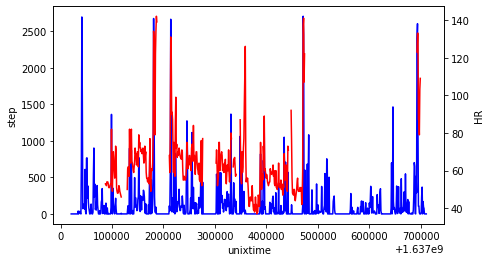

In [132]:
fig, ax = plt.subplots(figsize=(7, 4))

ax1 = ax.twinx()
 
ax.plot(df_np[:,0],df_np[:,2],c="b")
ax1.plot(df_np[:,0],df_np[:,1],c="r")

ax.set_ylabel("step")
ax1.set_ylabel("HR")
ax.set_xlabel("unixtime")

## ②これらのデータを使って安静時心拍数を求めよ。

安静時をステップが0の時と定義する。

In [109]:
hr = df_np[df_np[:,2]==0][:,1]
hrrest = hr[~np.isnan(hr)]

データファイルをみると、おかしなデータがある。例えばステップが0にもかかわらず、心拍数が明らかに高いときがある。そのような値は除外すべきである。


ヒストグラム、ボックスプロットを描写してデータの構成を確認する。

(array([32., 85., 18.,  1.,  0.,  1.,  3.,  0.,  1.,  3.]),
 array([ 37. ,  47.5,  58. ,  68.5,  79. ,  89.5, 100. , 110.5, 121. ,
        131.5, 142. ]),
 <a list of 10 Patch objects>)

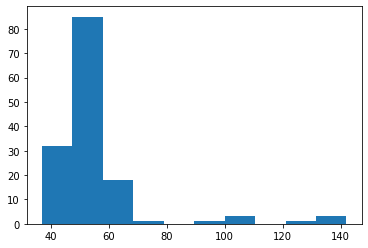

In [135]:
plt.hist(hrrest)

{'boxes': [<matplotlib.lines.Line2D at 0x7f33448e2a90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3344869b10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f334486fb50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f334486f610>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3344869090>,
  <matplotlib.lines.Line2D at 0x7f33448695d0>]}

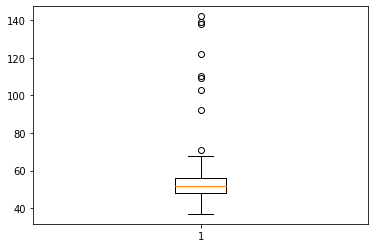

In [136]:
plt.boxplot(hrrest)

念のため、コルモゴロフ・スミルノフ検定およびシャピロ・ウィルク検定を実施する。

In [122]:
stats.shapiro(hrrest)

(0.5842590928077698, 1.719576144599736e-18)

In [125]:
stats.kstest(hrrest,"norm")

KstestResult(statistic=1.0, pvalue=0.0)

qqプロットを描写する。

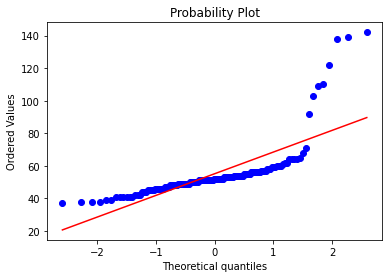

In [159]:
fig = plt.figure()
figqq = stats.probplot(hrrest, dist="norm", plot=plt)

以上の点から、hrrestに格納されているデータは正規分布とは言えない。外れ値があると考える。

箱ひげ図から、外れ値の80以上のデータを除外して検定およびqqプロット描写を行う。

(array([ 6.,  9., 17., 24., 34., 27.,  9.,  7.,  1.,  2.]),
 array([37. , 40.4, 43.8, 47.2, 50.6, 54. , 57.4, 60.8, 64.2, 67.6, 71. ]),
 <a list of 10 Patch objects>)

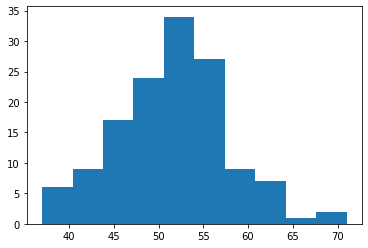

In [137]:
plt.hist(hrrest[hrrest<80])

{'boxes': [<matplotlib.lines.Line2D at 0x7f33447dc490>],
 'caps': [<matplotlib.lines.Line2D at 0x7f33447e4510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f334476a550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f33447e4fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f33447dca50>,
  <matplotlib.lines.Line2D at 0x7f33447dcf90>]}

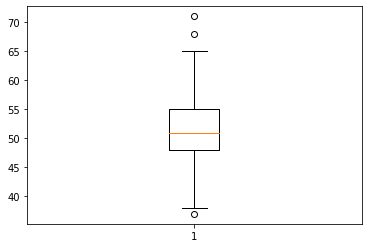

In [138]:
plt.boxplot(hrrest[hrrest<80])

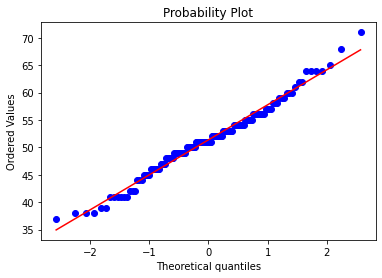

In [163]:
fig = plt.figure()
figqq = stats.probplot(hrrest[hrrest<80], dist="norm", plot=plt)

qqプロットから現時点のデータは正規分布に従うものと考えて問題ないと思われる。

安静時の心拍数

In [166]:
print(f"安静時心拍数：{np.mean(hrrest[hrrest<80],dtype=np.int)} bpm")

安静時心拍数：51 bpm


## ③この8日間うち、最高心拍数の値と、その時の歩数を求める。

In [157]:
hr_move = df_np[df_np[:,2]>0]
hr_move_new = hr_move[~np.isnan(hr_move).any(axis=1), :]
n = np.argmax(hr_move_new[:,1])
print(f"運動中の最大心拍数時のステップ数は{hr_move_new[n,2]}歩である。")

運動中の最大心拍数時のステップ数は2457.0歩である。
